## KFOLD & CATBOOSTREGRESSOR

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import keras

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
warnings.filterwarnings('ignore')

In [7]:
train = pd.read_csv('../input/train.csv',parse_dates=True)
test = pd.read_csv('../input/test.csv',parse_dates=True)
print('train shape:', train.shape)
print('test shape:', test.shape)


train shape: (7111, 12)
test shape: (2247, 9)


In [8]:
train.shape

(7111, 12)

In [9]:
train=train.loc[~(train['date_time']=='2011-01-01 00:00:00')].reset_index(drop=True)
all_data = pd.concat([train, test])
# convert to datatime format
all_data['date_time'] = pd.to_datetime(all_data['date_time'])
all_data.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


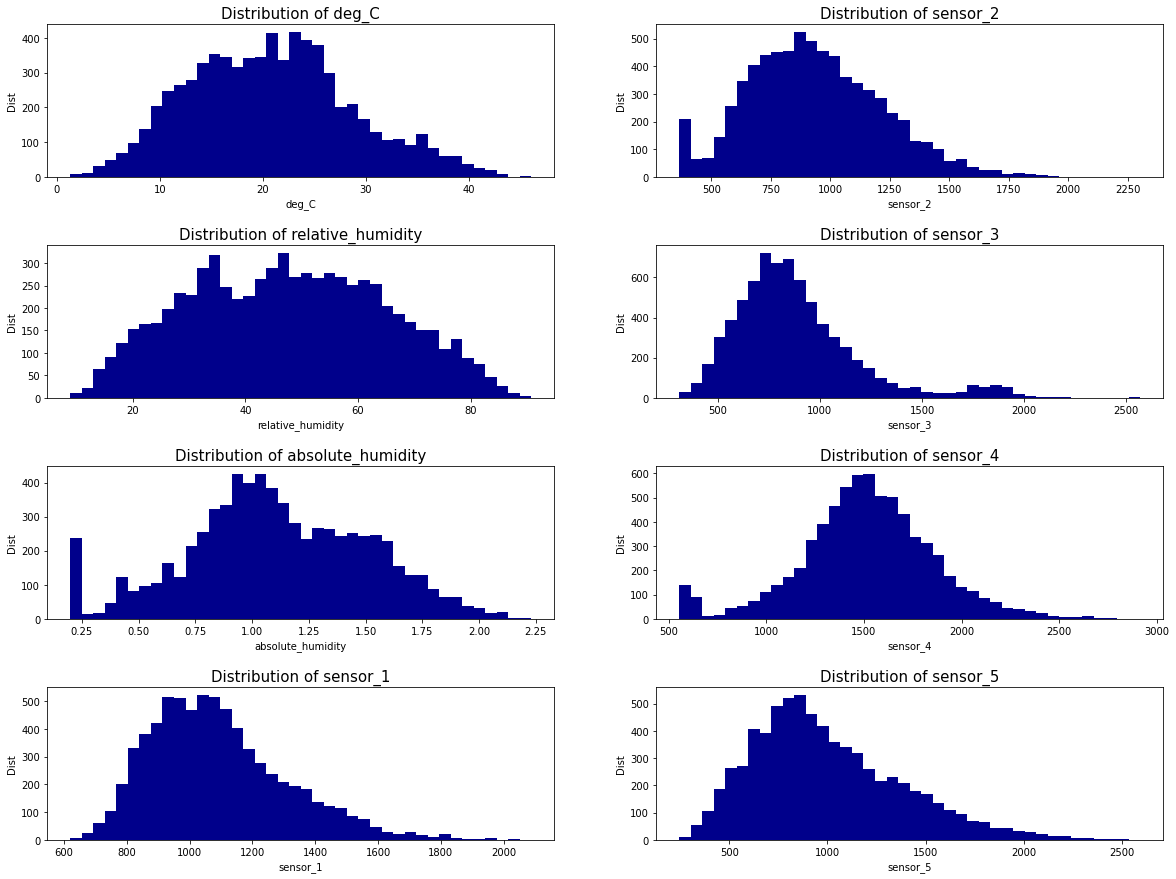

In [10]:
fig,ax=plt.subplots(4,2,figsize=(20,15))
for i,col in enumerate(train.columns[1:9]):
    ax[i%4][i//4].hist(train[col],bins=40,color='darkblue',label=f'{col}')
    ax[i%4][i//4].set_title(f'Distribution of {col}',fontsize=15)
    ax[i%4][i//4].set_xlabel(f'{col}')
    ax[i%4][i//4].set_ylabel('Dist')
    plt.subplots_adjust(hspace=0.45)

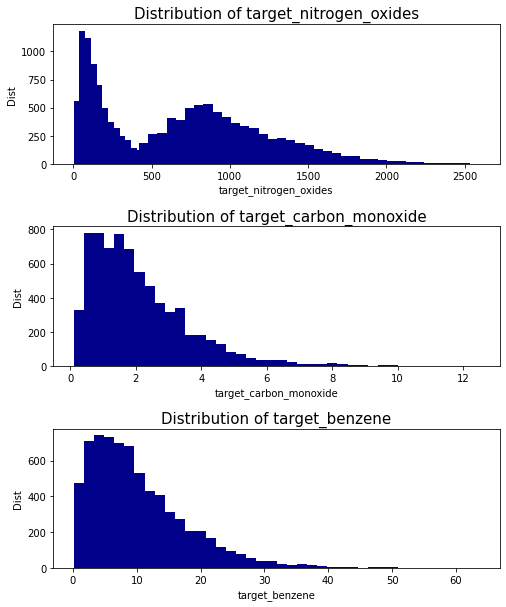

In [11]:
fig,ax=plt.subplots(3,1,figsize=(8,10))
for i,col in enumerate(train.columns[8:12]):
    ax[i%3].hist(train[col],bins=40,color='darkblue',label=f'{col}')
    ax[i%3].set_title(f'Distribution of {col}',fontsize=15)
    ax[i%3].set_xlabel(f'{col}')
    ax[i%3].set_ylabel('Dist')
    plt.subplots_adjust(hspace=0.45)

Text(0.5, 0, '')

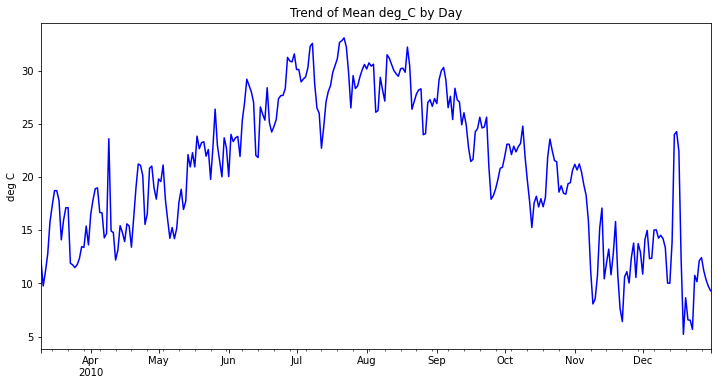

In [12]:
train['date_time']=pd.to_datetime(train['date_time'],format='%Y-%m-%d %H:%M:%S')
test['date_time']=pd.to_datetime(test['date_time'],format='%Y-%m-%d %H:%M:%S')
# Following code is inspired from - https://www.kaggle.com/nroman/eda-for-ashrae
fig,ax=plt.subplots(1,1,figsize=(12,6))
train[['date_time','deg_C']].set_index('date_time').resample('D').mean()['deg_C'].plot(ax=ax,label='by hour(train)',alpha=1,color='blue').set_ylabel('deg C',fontsize=10)
ax.set_title('Trend of Mean deg_C by Day',fontsize=12)
ax.set_xlabel('')

Text(0.5, 0, '')

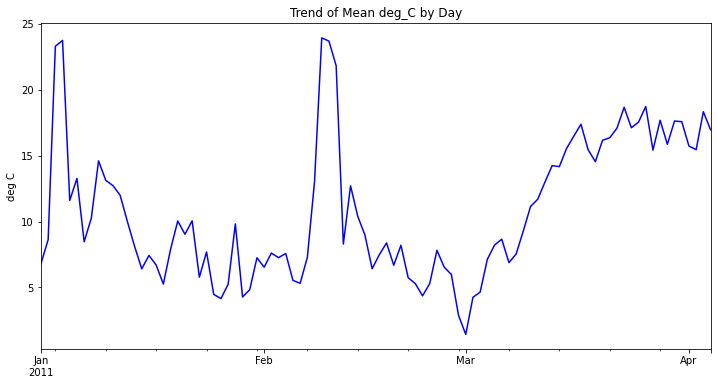

In [13]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
test[['date_time','deg_C']].set_index('date_time').resample('D').mean()['deg_C'].plot(ax=ax,label='by hour(train)',alpha=1,color='blue').set_ylabel('deg C',fontsize=10)
ax.set_title('Trend of Mean deg_C by Day',fontsize=12)
ax.set_xlabel('')

In [14]:
all_data.isnull().sum()

date_time                    0
deg_C                        0
relative_humidity            0
absolute_humidity            0
sensor_1                     0
sensor_2                     0
sensor_3                     0
sensor_4                     0
sensor_5                     0
target_carbon_monoxide    2247
target_benzene            2247
target_nitrogen_oxides    2247
dtype: int64

In [15]:

all_data["hour"] = all_data["date_time"].dt.hour
all_data["working_hours"] =  all_data["hour"].isin(np.arange(8, 21, 1)).astype("int")
all_data["is_weekend"] = (all_data["date_time"].dt.dayofweek >= 5).astype("int")
all_data['hr'] = all_data.date_time.dt.hour*60+all_data.date_time.dt.minute
all_data['satday'] = (all_data.date_time.dt.weekday==5).astype("int")
# add sensor shift. Inspired by kaggle user Tsai Yi Lin
all_data["s1-6"] = all_data["sensor_1"] - all_data["sensor_1"].shift(periods=6, fill_value=0)
all_data["s2-6"] = all_data["sensor_2"] - all_data["sensor_2"].shift(periods=6, fill_value=0)
all_data["s3-6"] = all_data["sensor_3"] - all_data["sensor_3"].shift(periods=6, fill_value=0)
all_data["s4-6"] = all_data["sensor_4"] - all_data["sensor_4"].shift(periods=6, fill_value=0)
all_data["s5-6"] = all_data["sensor_5"] - all_data["sensor_5"].shift(periods=6, fill_value=0)
all_data.drop(columns = 'hour', inplace = True)
# convert datetime to timestamp(s)
all_data['time'] = all_data['date_time'].astype(np.int64)//10**9
all_data.drop(columns = 'date_time', inplace = True)

In [17]:
all_data.columns

Index(['deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1',
       'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
       'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides',
       'working_hours', 'is_weekend', 'hr', 'satday', 's1-6', 's2-6', 's3-6',
       's4-6', 's5-6', 'time'],
      dtype='object')

In [18]:
X=all_data[:len(train)].drop(columns = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides',
                                       'satday','working_hours','s2-6','relative_humidity']).values
y=all_data[:len(train)][['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']]

In [19]:
y_log=np.log1p(y)
X_test=all_data[len(train):].drop(columns = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides',
                                       'satday','working_hours','s2-6','relative_humidity']).values

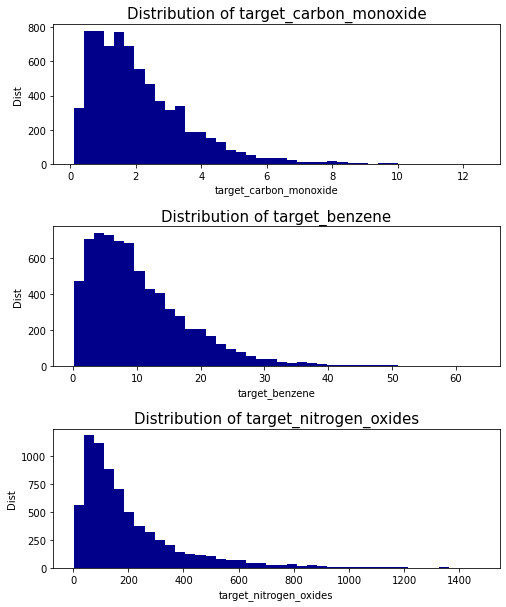

In [20]:
fig,ax=plt.subplots(3,1,figsize=(8,10))
for i,col in enumerate(y_log):
    ax[i%3].hist(train[col],bins=40,color='darkblue',label=f'{col}')
    ax[i%3].set_title(f'Distribution of {col}',fontsize=15)
    ax[i%3].set_xlabel(f'{col}')
    ax[i%3].set_ylabel('Dist')
    plt.subplots_adjust(hspace=0.45)

In [21]:
print('X_train shape:', X.shape)
print('y_train shape:', y.shape)
print('X_test shape:', X_test.shape)


X_train shape: (7110, 14)
y_train shape: (7110, 3)
X_test shape: (2247, 14)


In [ ]:
cb_params = [
                {'learning_rate': 0.010169009412219588,
                 'l2_leaf_reg': 8.908337085912136,
                 'bagging_temperature': 8.384477224270551,
                 'random_strength': 1.950237493637981,
                 'depth': 6,
                 'grow_policy': 'Lossguide',
                 'leaf_estimation_method': 'Newton'},
                {'learning_rate': 0.166394867169309,
                 'l2_leaf_reg': 8.704675157564441,
                 'bagging_temperature': 3.340826164726799,
                 'random_strength': 1.538518016574368,
                 'depth': 3,
                 'grow_policy': 'Depthwise',
                 'leaf_estimation_method': 'Newton'},
                {'learning_rate': 0.028141156076957437,
                 'l2_leaf_reg': 3.116523267336638,
                 'bagging_temperature': 4.420661209459851,
                 'random_strength': 1.8011752694610028,
                 'depth': 6,
                 'grow_policy': 'Depthwise',
                 'leaf_estimation_method': 'Newton'},
]

In [ ]:
preds = pd.read_csv('../output/submission2.csv')

In [ ]:
%%time
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import LeaveOneGroupOut
from catboost import CatBoostRegressor

all_fi = []
splits = 10
target_names=y_log.columns

for i, target in enumerate(target_names):
    print(f"\nTraining for {target}...")
    logo = LeaveOneGroupOut()
    oof_preds = np.zeros((X.shape[0],))
    model_preds = 0
    model_fi = 0
    for num, (train_idx, valid_idx) in enumerate(logo.split(X, y_log, months)):
        X_train, X_valid = X[[train_idx]], X[[valid_idx]]
        y_train, y_valid = y_log.loc[train_idx, target], y_log.loc[valid_idx, target]
        model = CatBoostRegressor(random_state=42,
                                 thread_count=4,
                                 verbose=False,
                                 loss_function='RMSE',
                                 eval_metric='RMSE',
                                 od_type="Iter",
                                 early_stopping_rounds=500,
                                 use_best_model=True,
                                 iterations=10000,
                                 task_type="CPU",
                                 **cb_params[i])
        
        model.fit(X_train, y_train,
                  eval_set=(X_valid, y_valid),
                  verbose=False)
        model_preds += np.expm1(model.predict(X_test)) / splits
        model_fi += model.feature_importances_
        oof_preds[valid_idx] = np.expm1(model.predict(X_valid))
        print(f"Fold {num} RMSLE: {np.sqrt(mean_squared_log_error(np.expm1(y_valid), oof_preds[valid_idx]))}")
    print(f"\nOverall RMSLE: {np.sqrt(mean_squared_log_error(np.expm1(y_log[target]), oof_preds))}")    
    preds[target] = model_preds
    all_fi.append(dict(zip(all_data.columns, model_fi)))

In [ ]:
submission = preds.set_index('date_time')

In [ ]:
preds.to_csv('submission10.csv', index=False)

Thanks to @Tsai Yi Lin - CatBoost_18Feature_Cross_Validation